In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


2.16.1


In [25]:
# Set batch size for training
BATCH_SIZE = 256

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

NUM_CLASSES=5

In [4]:
import numpy as np

data = np.load("/kaggle/input/mars-dataset/mars_for_students.npz")
training_set = data["training_set"]

X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

## Data cleaning

In [5]:
# Get the reference label (y_train[62])
reference_label = y_train[62]

# Filter the dataset where y_train is not equal to the reference label
mask = [not np.array_equal(label, reference_label) for label in y_train]

print(f"Original dataset size: {len(X_train)}")

X_train = X_train[mask]
y_train = y_train[mask]

print(f"Filtered dataset size: {len(X_train)}")

Original dataset size: 2615
Filtered dataset size: 2505


Img 0


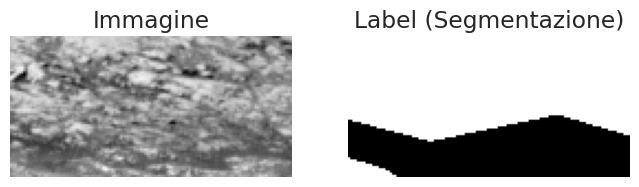

Img 1


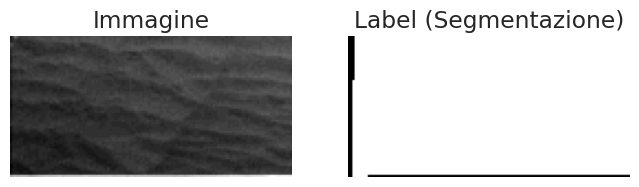

Img 2


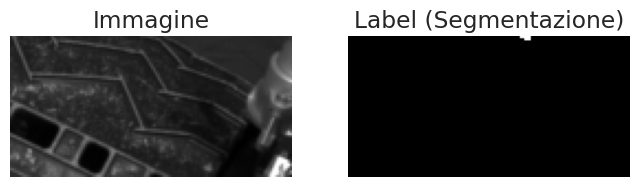

Img 3


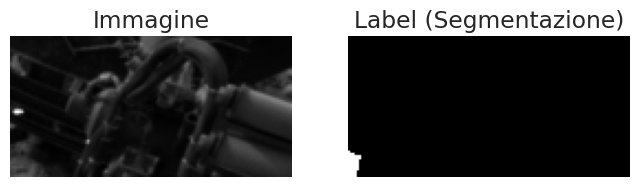

Img 4


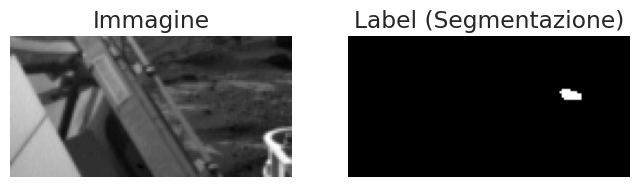

Img 5


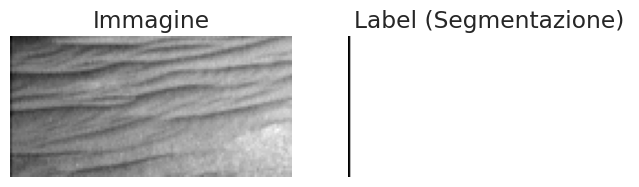

Img 6


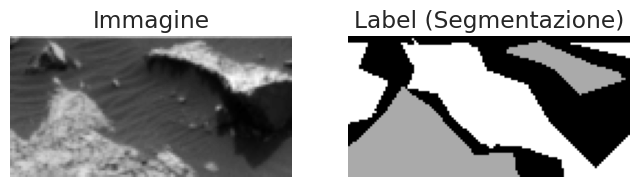

Img 7


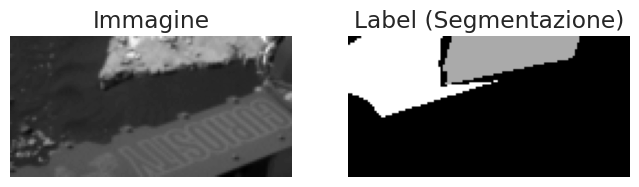

Img 8


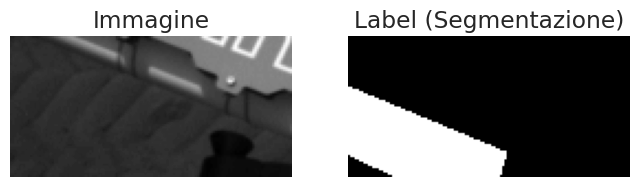

Img 9


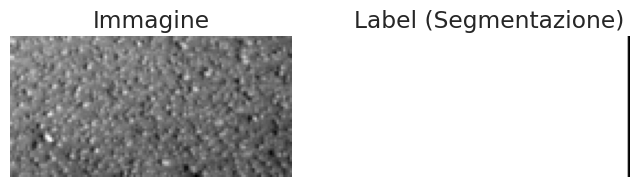

Img 10


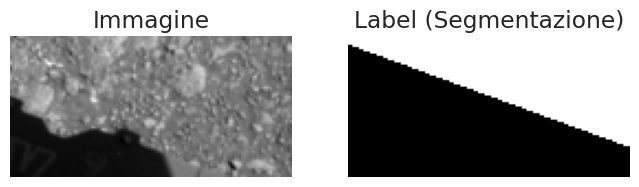

In [6]:
import matplotlib.pyplot as plt

# Supponiamo che X_train contenga le immagini e y_train le etichette di segmentazione
for i, (img, label) in enumerate(zip(X_train, y_train)):
    plt.figure(figsize=(8, 4))
    
    print("Img " + str(i))
    
    # Immagine originale
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
    plt.title("Immagine")
    plt.axis('off')
    
    # Label di segmentazione
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap='gray' if len(label.shape) == 2 else None)
    plt.title("Label (Segmentazione)")
    plt.axis('off')
    
    plt.show()

    
    # Limita il numero di immagini mostrate, ad esempio a 10
    if i >= 10:
        break


In [7]:
# Flatten y_train to aggregate pixel counts across all images
all_pixels = np.concatenate([y.flatten() for y in y_train])

# Count the occurrences of each class
unique_classes, counts = np.unique(all_pixels, return_counts=True)

# Calculate the total number of pixels
total_pixels = all_pixels.size

# Calculate the percentage of each class
class_percentages = {cls: (count / total_pixels) * 100 for cls, count in zip(unique_classes, counts)}

# Print results
print("Class percentages:")
for cls, percentage in class_percentages.items():
    print(f"Class {cls}: {percentage:.2f}%")

Class percentages:
Class 0.0: 24.31%
Class 1.0: 33.90%
Class 2.0: 23.28%
Class 3.0: 18.38%
Class 4.0: 0.13%


In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=seed
)

In [9]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [38]:
import keras_cv

def augmentation_layer():
    return tf.keras.Sequential([
        tf.keras.layers.RandomBrightness(0.1),
        keras_cv.layers.RandomContrast([0, 255], 0.2),
        keras_cv.layers.RandomGaussianBlur(2, 1),
        tf.keras.layers.GaussianNoise(0.05)
    ])
    
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    input_layer = augmentation_layer()(input_layer)

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')  # Additional downsampling block
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 256, name='down_block4_')  # Another additional downsampling block
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck
    bottleneck = unet_block(d4, 512, name='bottleneck')

    # Upsampling path
    u4 = tfkl.UpSampling2D()(bottleneck)
    u4 = tfkl.Concatenate()([u4, down_block_4])
    u4 = unet_block(u4, 256, name='up_block4_')

    u3 = tfkl.UpSampling2D()(u4)
    u3 = tfkl.Concatenate()([u3, down_block_3])
    u3 = unet_block(u3, 128, name='up_block3_')

    u2 = tfkl.UpSampling2D()(u3)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u1 = tfkl.UpSampling2D()(u2)
    u1 = tfkl.Concatenate()([u1, down_block_1])
    u1 = unet_block(u1, 32, name='up_block1_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u1)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [11]:
category_map = {
        0: 0,  # unlabelled
        1: 1,
        2: 2,
        3: 3,
        4: 4
}
    
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(int(label))

In [12]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""

    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)

    
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )

    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [13]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    images = tf.expand_dims(images, axis=-1)  # Ensure images have a single channel (grayscale or RGB)
    
    # One-hot encode the labels and convert to uint8
    labels = tf.cast(labels, tf.uint8)  # Convert labels to uint8
    labels = tf.keras.backend.one_hot(labels, NUM_CLASSES)  # One-hot encoding the labels
    
    # Create dataset from images and one-hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping if needed (you can modify this function as necessary)
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),  # You can define apply_category_mapping based on your needs
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),  # Define random_flip for augmentation if necessary
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [14]:
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=25,
    shuffle=True,
    augment=True,
    seed=seed
)

In [15]:
# Print the shape of a single batch from the train_dataset
for img_batch, lbl_batch in train_dataset.take(1):  # Taking the first batch
    print("Image batch shape:", img_batch.shape)
    print("Label batch shape:", lbl_batch.shape)


Image batch shape: (256, 64, 128, 1)
Label batch shape: (256, 64, 128, 5)


In [39]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = get_unet_model()

In [17]:
import random

# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.math.argmax(y_true, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, images, labels, frequency=5):
        super().__init__()
        self.images = images
        self.labels = labels
        self.frequency = frequency

    def apply_colormap(self, label, colormap=None):
        """
        Apply the colormap to a label.
        """
        # Ensure label is 2D
        label = np.squeeze(label)
    
        if colormap is None:
            num_classes = len(np.unique(label))
            colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))
    
        # Apply the colormap
        colored = colormap[label.astype(int)]
    
        return colored

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            idx = random.randint(0, len(self.images))
            image = self.images[idx]
            label = self.labels[idx]
            
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = self.apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = self.apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [41]:
import tensorflow as tf
import tensorflow.keras.backend as K

import tensorflow as tf
import numpy as np

total_percentage = sum(class_percentages.values())
class_weights = {cls: total_percentage / percentage for cls, percentage in class_percentages.items()}

# Convert class_weights to a tensor (use in TensorFlow/Keras)
class_weights_tensor = tf.constant([class_weights[c] for c in sorted(class_weights.keys())], dtype=tf.float32)

def weighted_categorical_crossentropy(y_true, y_pred):
    """
    Weighted Categorical Cross-Entropy Loss
    """
    # Ensure y_pred is normalized (softmax)
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    
    # Compute cross-entropy
    cross_entropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
    
    # Apply class weights
    weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)
    weighted_cross_entropy = weights * cross_entropy
    return tf.reduce_mean(weighted_cross_entropy)

def dice_loss(y_true, y_pred):
    """
    Dice Loss for multi-class segmentation
    """
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = numerator / (denominator + tf.keras.backend.epsilon())
    return 1 - tf.reduce_mean(dice)

def combined_loss(y_true, y_pred, lambda_=0.5):
    """
    Combined Loss: Weighted Categorical Cross-Entropy + Dice Loss
    """
    loss_ce = weighted_categorical_crossentropy(y_true, y_pred)
    loss_dice = dice_loss(y_true, y_pred)
    return lambda_ * loss_ce + (1 - lambda_) * loss_dice


# Compile the model with the custom combined loss
print("Compiling model...")
with strategy.scope():
    model.compile(
        loss=combined_loss,
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
        metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
    )
print("Model compiled!")


Compiling model...
Model compiled!


In [42]:
# Setup callbacks
with strategy.scope():
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=20,
        restore_best_weights=True
    )
    
    viz_callback = VizCallback(X_val, y_val)

Epoch 1/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2093 - loss: 5.0400 - mean_iou: 0.0844   

W0000 00:00:1733242200.669315      23 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 1 } dim { size: 64 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 1 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12030" } environment { key: "cudnn" value: "8906" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multipro

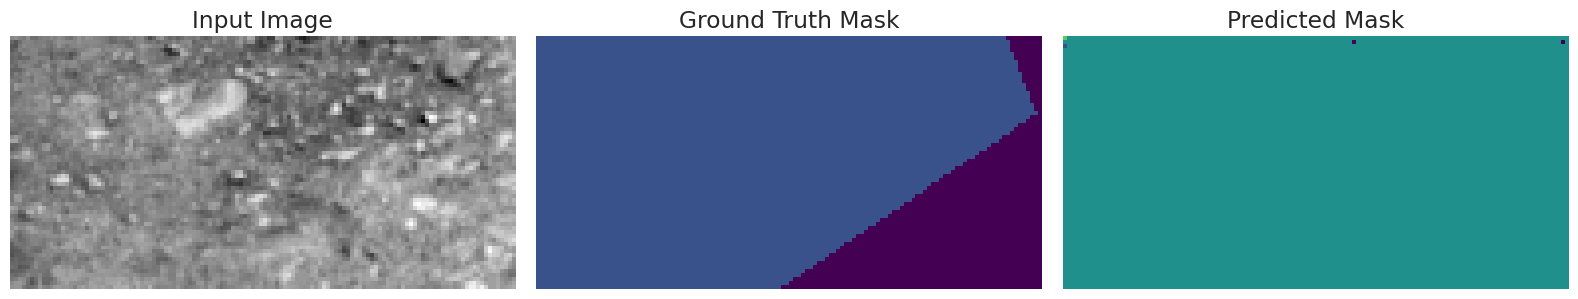

9/9 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.2104 - loss: 5.0177 - mean_iou: 0.0853 - val_accuracy: 0.1961 - val_loss: 6.0728 - val_mean_iou: 0.0513
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 685ms/step - accuracy: 0.2874 - loss: 4.0652 - mean_iou: 0.1536 - val_accuracy: 0.1865 - val_loss: 5.6645 - val_mean_iou: 0.0501
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 674ms/step - accuracy: 0.3389 - loss: 3.8804 - mean_iou: 0.1911 - val_accuracy: 0.2225 - val_loss: 4.9150 - val_mean_iou: 0.0646
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 660ms/step - accuracy: 0.3802 - loss: 3.6793 - mean_iou: 0.2230 - val_accuracy: 0.2421 - val_loss: 4.3530 - val_mean_iou: 0.0683
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 652ms/step - accuracy: 0.4167 - loss: 3.3538 - mean_iou: 0.2438 - val_accuracy: 0.2153 - val_loss: 4.4285 - val_mean_iou: 0.0714
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.4442 - loss: 3.2117 - mean_iou: 0.2581

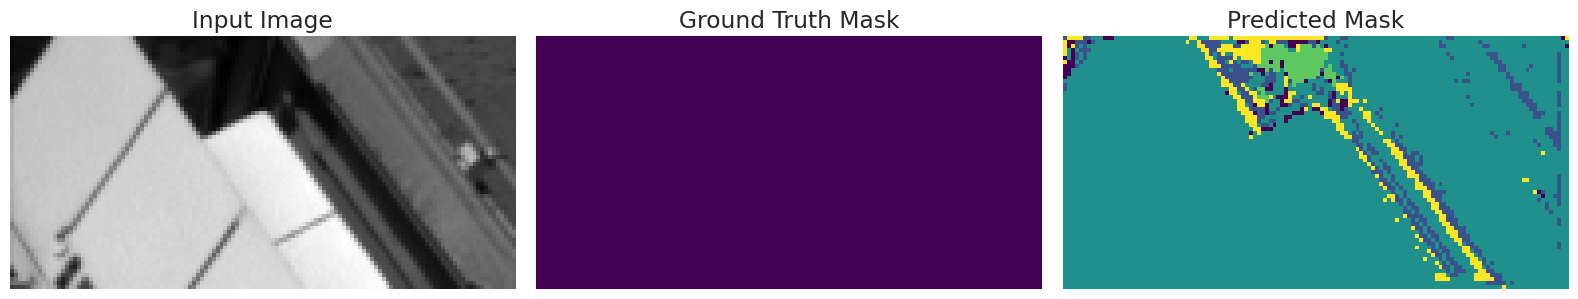

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 744ms/step - accuracy: 0.4449 - loss: 3.2058 - mean_iou: 0.2586 - val_accuracy: 0.2992 - val_loss: 4.9224 - val_mean_iou: 0.1300
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 659ms/step - accuracy: 0.4833 - loss: 3.0513 - mean_iou: 0.2806 - val_accuracy: 0.3054 - val_loss: 4.1112 - val_mean_iou: 0.1326
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 667ms/step - accuracy: 0.5171 - loss: 2.9134 - mean_iou: 0.3049 - val_accuracy: 0.3137 - val_loss: 4.5846 - val_mean_iou: 0.1362
Epoch 9/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 664ms/step - accuracy: 0.5316 - loss: 2.8833 - mean_iou: 0.3153 - val_accuracy: 0.3494 - val_loss: 3.8624 - val_mean_iou: 0.1679
Epoch 10/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 688ms/step - accuracy: 0.5539 - loss: 2.8095 - mean_iou: 0.3295 - val_accuracy: 0.3914 - val_loss: 4.0881 - val_mean_iou: 0.1898
Epoch 11/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.5695 - loss: 2.7998 - mean_iou: 0.3333

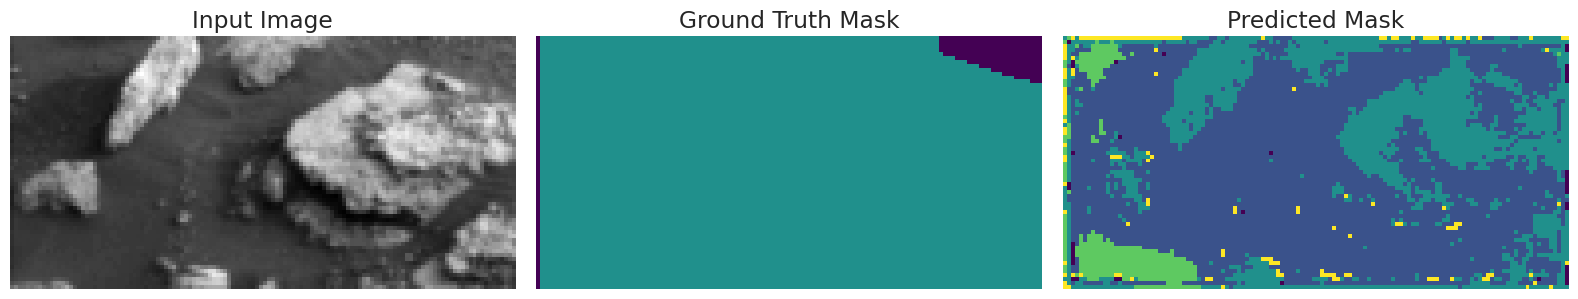

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 762ms/step - accuracy: 0.5725 - loss: 2.7781 - mean_iou: 0.3344 - val_accuracy: 0.4076 - val_loss: 3.7442 - val_mean_iou: 0.2142
Epoch 12/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 672ms/step - accuracy: 0.5922 - loss: 2.5969 - mean_iou: 0.3479 - val_accuracy: 0.3894 - val_loss: 3.7035 - val_mean_iou: 0.2315
Epoch 13/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 675ms/step - accuracy: 0.6110 - loss: 2.5489 - mean_iou: 0.3663 - val_accuracy: 0.3953 - val_loss: 3.6678 - val_mean_iou: 0.1676
Epoch 14/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 686ms/step - accuracy: 0.6316 - loss: 2.5294 - mean_iou: 0.3854 - val_accuracy: 0.4150 - val_loss: 3.8894 - val_mean_iou: 0.1934
Epoch 15/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 665ms/step - accuracy: 0.6318 - loss: 2.5053 - mean_iou: 0.3872 - val_accuracy: 0.3276 - val_loss: 4.3283 - val_mean_iou: 0.1335
Epoch 16/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.6503 - loss: 2.3698 - mean_iou: 0.3923

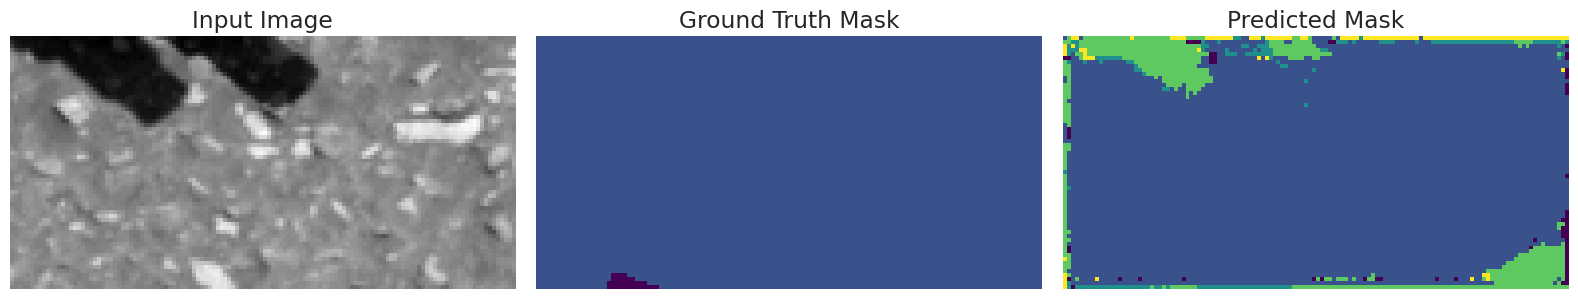

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 769ms/step - accuracy: 0.6517 - loss: 2.3566 - mean_iou: 0.3932 - val_accuracy: 0.4768 - val_loss: 3.6851 - val_mean_iou: 0.2349
Epoch 17/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 664ms/step - accuracy: 0.6632 - loss: 2.2570 - mean_iou: 0.4026 - val_accuracy: 0.4541 - val_loss: 3.4336 - val_mean_iou: 0.2226
Epoch 18/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 657ms/step - accuracy: 0.6738 - loss: 2.2763 - mean_iou: 0.4162 - val_accuracy: 0.4342 - val_loss: 3.9061 - val_mean_iou: 0.1940
Epoch 19/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 661ms/step - accuracy: 0.6837 - loss: 2.1702 - mean_iou: 0.4242 - val_accuracy: 0.3925 - val_loss: 3.5077 - val_mean_iou: 0.1786
Epoch 20/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 661ms/step - accuracy: 0.6947 - loss: 2.0971 - mean_iou: 0.4294 - val_accuracy: 0.4415 - val_loss: 3.6260 - val_mean_iou: 0.2221
Epoch 21/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.6909 - loss: 2.1348 - mean_iou: 0.4413

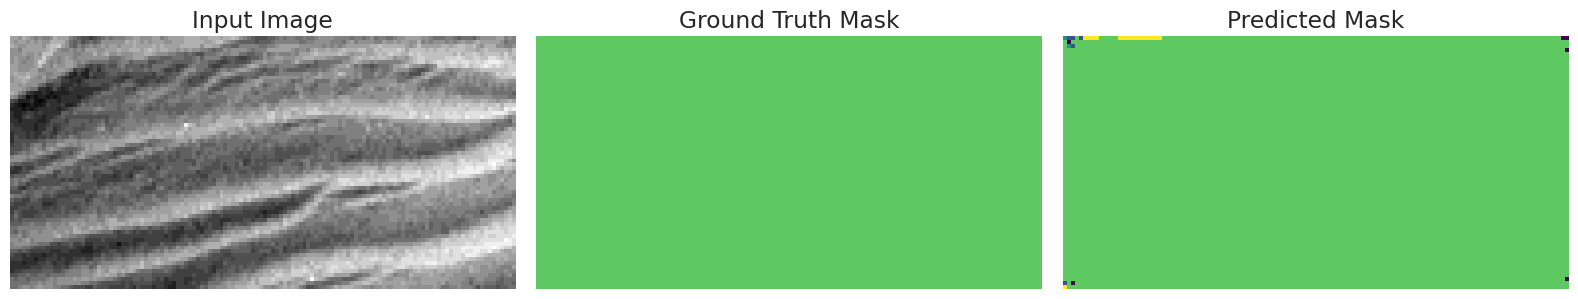

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 746ms/step - accuracy: 0.6922 - loss: 2.1403 - mean_iou: 0.4406 - val_accuracy: 0.4532 - val_loss: 3.7967 - val_mean_iou: 0.2451
Epoch 22/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 669ms/step - accuracy: 0.7073 - loss: 2.0255 - mean_iou: 0.4526 - val_accuracy: 0.5018 - val_loss: 3.3130 - val_mean_iou: 0.2410
Epoch 23/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 671ms/step - accuracy: 0.6987 - loss: 2.0874 - mean_iou: 0.4334 - val_accuracy: 0.5548 - val_loss: 3.0393 - val_mean_iou: 0.3004
Epoch 24/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 669ms/step - accuracy: 0.6959 - loss: 2.0476 - mean_iou: 0.4370 - val_accuracy: 0.5381 - val_loss: 2.7819 - val_mean_iou: 0.2961
Epoch 25/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 668ms/step - accuracy: 0.7113 - loss: 2.0186 - mean_iou: 0.4456 - val_accuracy: 0.5086 - val_loss: 2.9098 - val_mean_iou: 0.2572
Epoch 26/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.7009 - loss: 2.0397 - mean_iou: 0.4513

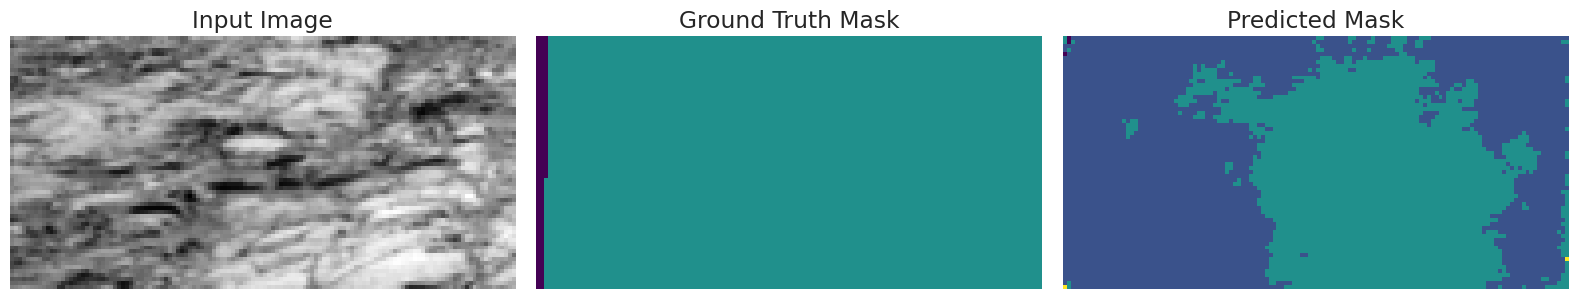

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 764ms/step - accuracy: 0.7015 - loss: 2.0311 - mean_iou: 0.4499 - val_accuracy: 0.5091 - val_loss: 3.8605 - val_mean_iou: 0.2849
Epoch 27/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 674ms/step - accuracy: 0.7186 - loss: 1.9243 - mean_iou: 0.4642 - val_accuracy: 0.5870 - val_loss: 2.8048 - val_mean_iou: 0.3443
Epoch 28/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 678ms/step - accuracy: 0.7386 - loss: 1.8256 - mean_iou: 0.4956 - val_accuracy: 0.5925 - val_loss: 3.0767 - val_mean_iou: 0.3402
Epoch 29/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 667ms/step - accuracy: 0.7326 - loss: 1.8122 - mean_iou: 0.4835 - val_accuracy: 0.5733 - val_loss: 3.6999 - val_mean_iou: 0.3571
Epoch 30/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 679ms/step - accuracy: 0.7416 - loss: 1.7806 - mean_iou: 0.5012 - val_accuracy: 0.5391 - val_loss: 2.8728 - val_mean_iou: 0.3314
Epoch 31/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.7459 - loss: 1.7548 - mean_iou: 0.5286

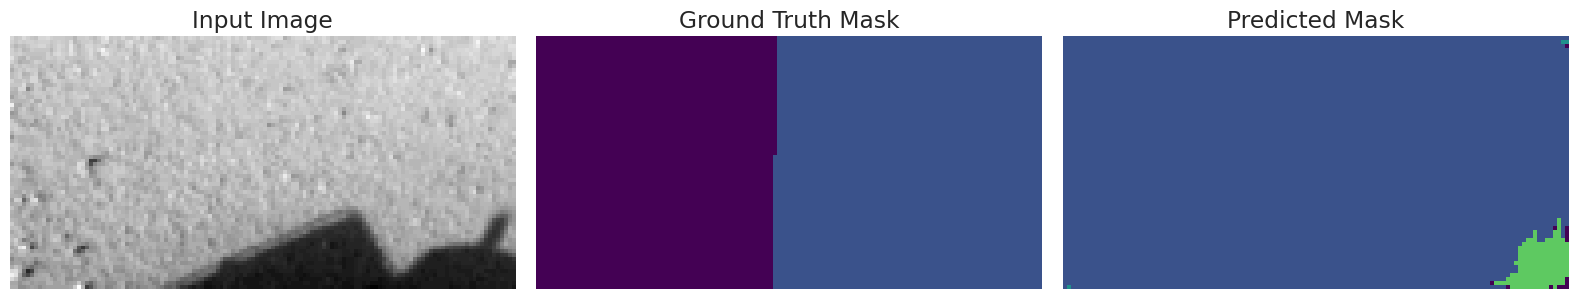

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 886ms/step - accuracy: 0.7470 - loss: 1.7456 - mean_iou: 0.5309 - val_accuracy: 0.5752 - val_loss: 3.1535 - val_mean_iou: 0.3164
Epoch 32/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 660ms/step - accuracy: 0.7523 - loss: 1.7234 - mean_iou: 0.5459 - val_accuracy: 0.5486 - val_loss: 3.3744 - val_mean_iou: 0.3386
Epoch 33/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 675ms/step - accuracy: 0.7429 - loss: 1.7383 - mean_iou: 0.5037 - val_accuracy: 0.6214 - val_loss: 2.9073 - val_mean_iou: 0.4062
Epoch 34/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 678ms/step - accuracy: 0.7590 - loss: 1.6566 - mean_iou: 0.5430 - val_accuracy: 0.6707 - val_loss: 2.8619 - val_mean_iou: 0.4153
Epoch 35/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 665ms/step - accuracy: 0.7667 - loss: 1.6248 - mean_iou: 0.5307 - val_accuracy: 0.6289 - val_loss: 3.1090 - val_mean_iou: 0.4235
Epoch 36/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.7657 - loss: 1.6078 - mean_iou: 0.5452

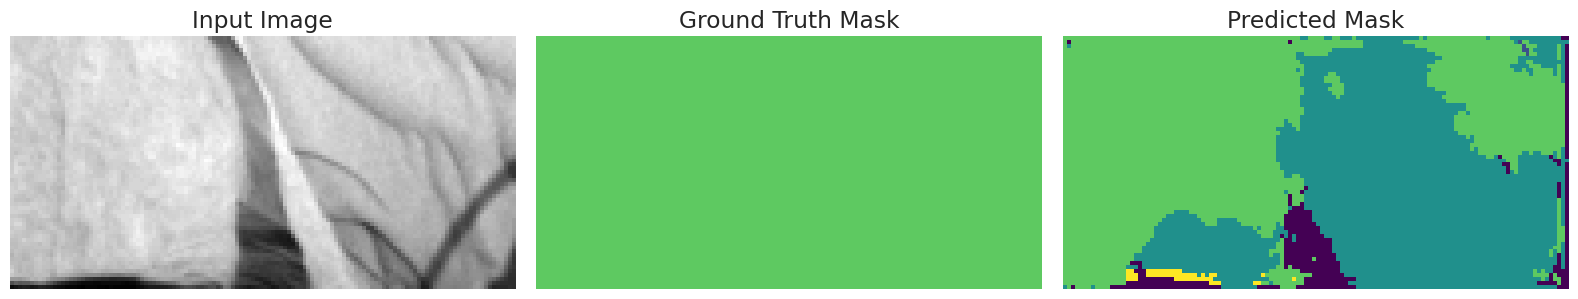

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 742ms/step - accuracy: 0.7672 - loss: 1.5976 - mean_iou: 0.5498 - val_accuracy: 0.6060 - val_loss: 2.6307 - val_mean_iou: 0.4372
Epoch 37/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 678ms/step - accuracy: 0.7826 - loss: 1.5163 - mean_iou: 0.5567 - val_accuracy: 0.5809 - val_loss: 3.5467 - val_mean_iou: 0.3903
Epoch 38/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 669ms/step - accuracy: 0.7763 - loss: 1.5470 - mean_iou: 0.5411 - val_accuracy: 0.6388 - val_loss: 2.4119 - val_mean_iou: 0.3910
Epoch 39/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 676ms/step - accuracy: 0.7778 - loss: 1.5213 - mean_iou: 0.5644 - val_accuracy: 0.6042 - val_loss: 3.3404 - val_mean_iou: 0.3599
Epoch 40/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 670ms/step - accuracy: 0.7802 - loss: 1.5154 - mean_iou: 0.5826 - val_accuracy: 0.6385 - val_loss: 2.9381 - val_mean_iou: 0.4424
Epoch 41/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.7909 - loss: 1.4555 - mean_iou: 0.5892

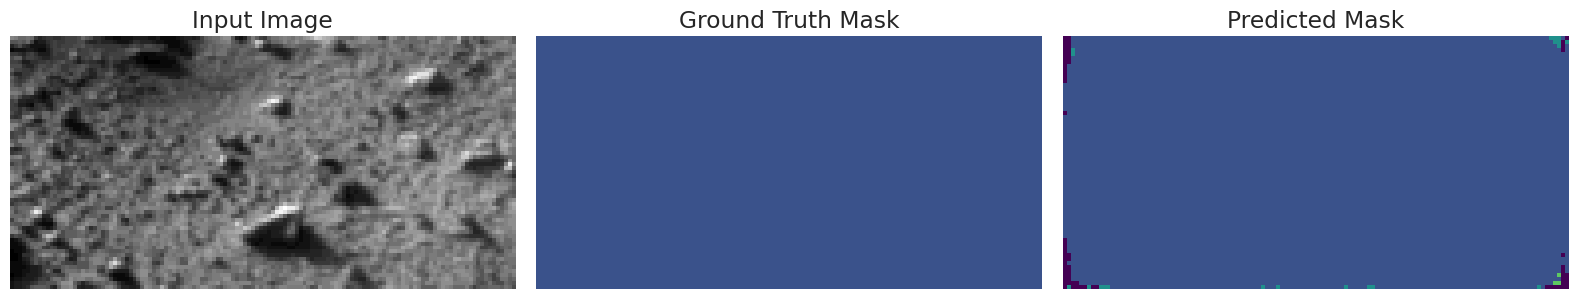

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 756ms/step - accuracy: 0.7920 - loss: 1.4494 - mean_iou: 0.5889 - val_accuracy: 0.6702 - val_loss: 3.3682 - val_mean_iou: 0.4487
Epoch 42/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 666ms/step - accuracy: 0.8061 - loss: 1.3524 - mean_iou: 0.6232 - val_accuracy: 0.6525 - val_loss: 2.4085 - val_mean_iou: 0.4644
Epoch 43/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 667ms/step - accuracy: 0.8040 - loss: 1.3953 - mean_iou: 0.6100 - val_accuracy: 0.6366 - val_loss: 3.3084 - val_mean_iou: 0.3782
Epoch 44/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 673ms/step - accuracy: 0.8072 - loss: 1.3511 - mean_iou: 0.6173 - val_accuracy: 0.6674 - val_loss: 2.6531 - val_mean_iou: 0.4549
Epoch 45/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 667ms/step - accuracy: 0.8218 - loss: 1.2580 - mean_iou: 0.6495 - val_accuracy: 0.6507 - val_loss: 2.2523 - val_mean_iou: 0.3825
Epoch 46/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8159 - loss: 1.3060 - mean_iou: 0.6388

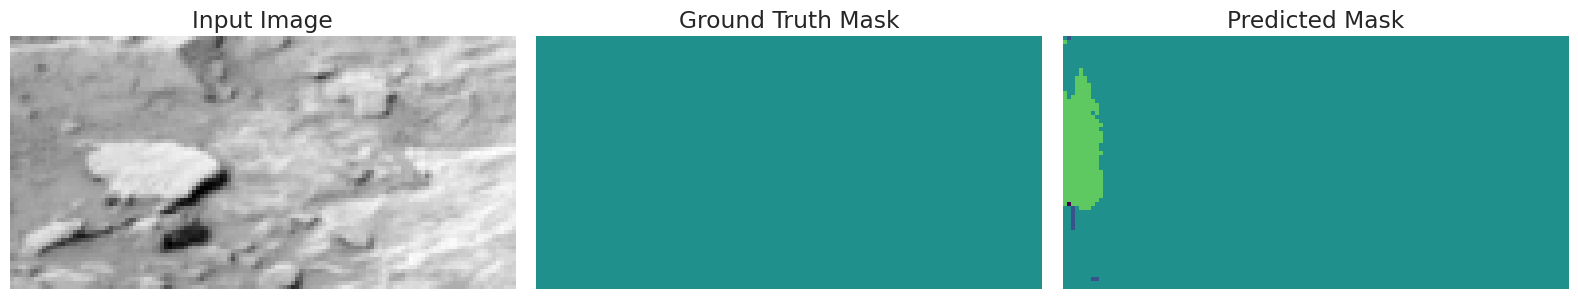

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 743ms/step - accuracy: 0.8168 - loss: 1.2994 - mean_iou: 0.6385 - val_accuracy: 0.6257 - val_loss: 3.4687 - val_mean_iou: 0.3899
Epoch 47/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 674ms/step - accuracy: 0.8121 - loss: 1.3007 - mean_iou: 0.6216 - val_accuracy: 0.7259 - val_loss: 1.8882 - val_mean_iou: 0.4294
Epoch 48/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 664ms/step - accuracy: 0.8180 - loss: 1.2652 - mean_iou: 0.6417 - val_accuracy: 0.6568 - val_loss: 2.8171 - val_mean_iou: 0.4585
Epoch 49/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 678ms/step - accuracy: 0.8321 - loss: 1.1991 - mean_iou: 0.6429 - val_accuracy: 0.7264 - val_loss: 2.2519 - val_mean_iou: 0.4734
Epoch 50/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 669ms/step - accuracy: 0.8303 - loss: 1.1694 - mean_iou: 0.6286 - val_accuracy: 0.6650 - val_loss: 2.9712 - val_mean_iou: 0.4185
Epoch 51/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8375 - loss: 1.1564 - mean_iou: 0.6417

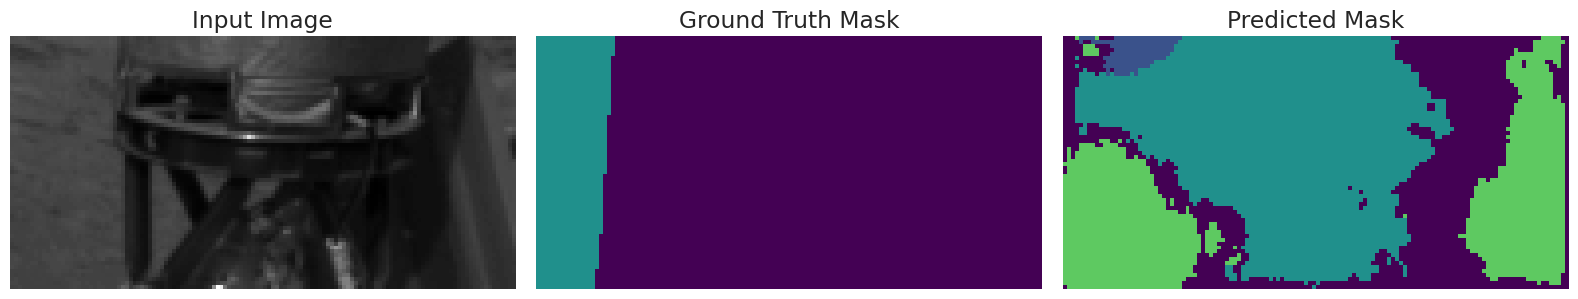

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 742ms/step - accuracy: 0.8387 - loss: 1.1488 - mean_iou: 0.6441 - val_accuracy: 0.6630 - val_loss: 2.7455 - val_mean_iou: 0.4760
Epoch 52/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 670ms/step - accuracy: 0.8423 - loss: 1.1277 - mean_iou: 0.6454 - val_accuracy: 0.6289 - val_loss: 3.3056 - val_mean_iou: 0.4279
Epoch 53/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 678ms/step - accuracy: 0.8342 - loss: 1.1550 - mean_iou: 0.6487 - val_accuracy: 0.6649 - val_loss: 3.0990 - val_mean_iou: 0.3701
Epoch 54/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 668ms/step - accuracy: 0.8301 - loss: 1.1783 - mean_iou: 0.6266 - val_accuracy: 0.6162 - val_loss: 2.9434 - val_mean_iou: 0.3590
Epoch 55/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 666ms/step - accuracy: 0.8381 - loss: 1.1135 - mean_iou: 0.6247 - val_accuracy: 0.6918 - val_loss: 3.1537 - val_mean_iou: 0.4217
Epoch 56/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.8486 - loss: 1.0718 - mean_iou: 0.6732

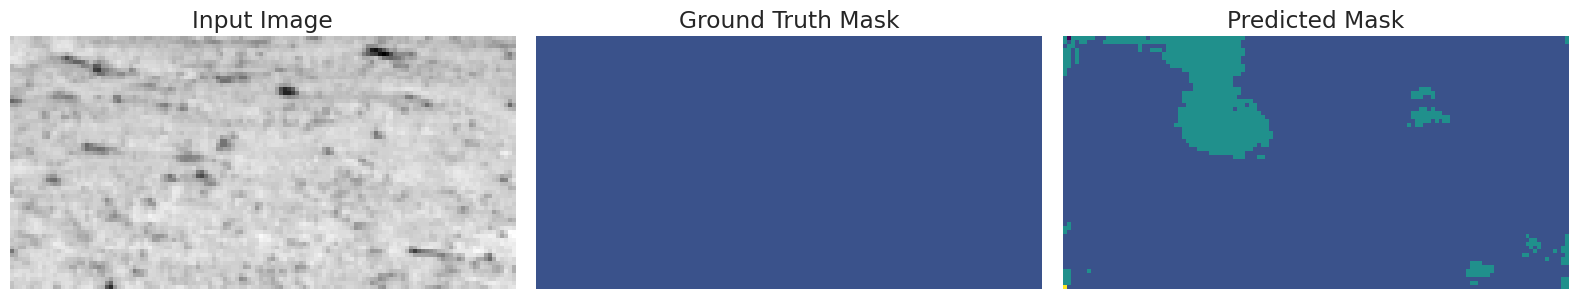

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 752ms/step - accuracy: 0.8489 - loss: 1.0687 - mean_iou: 0.6739 - val_accuracy: 0.6644 - val_loss: 2.3320 - val_mean_iou: 0.5172
Epoch 57/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 665ms/step - accuracy: 0.8626 - loss: 0.9947 - mean_iou: 0.6895 - val_accuracy: 0.6856 - val_loss: 3.2502 - val_mean_iou: 0.4669
Epoch 58/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 671ms/step - accuracy: 0.8503 - loss: 1.0577 - mean_iou: 0.6646 - val_accuracy: 0.6352 - val_loss: 3.1162 - val_mean_iou: 0.3688
Epoch 59/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 665ms/step - accuracy: 0.8552 - loss: 1.0201 - mean_iou: 0.6662 - val_accuracy: 0.6857 - val_loss: 2.1783 - val_mean_iou: 0.4308
Epoch 60/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 661ms/step - accuracy: 0.8721 - loss: 0.9414 - mean_iou: 0.6738 - val_accuracy: 0.7121 - val_loss: 2.5248 - val_mean_iou: 0.4416
Epoch 61/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.8687 - loss: 0.9445 - mean_iou: 0.6660

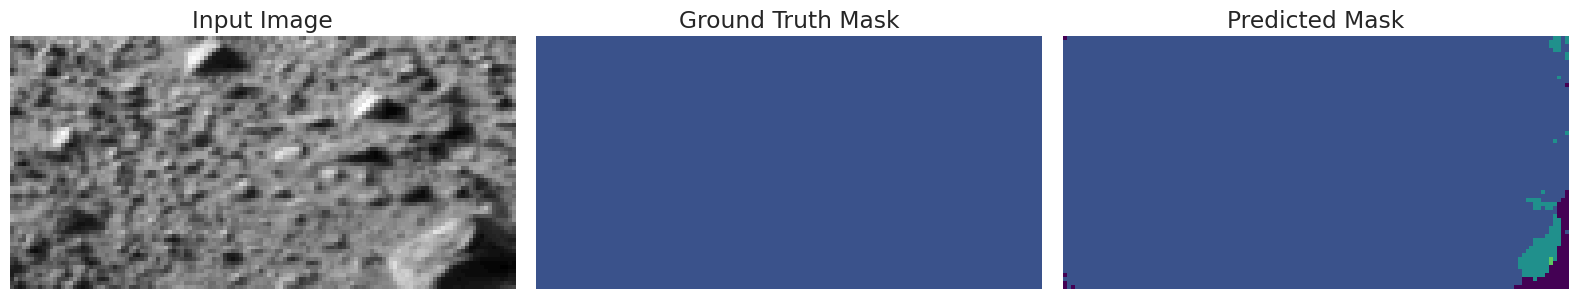

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 757ms/step - accuracy: 0.8703 - loss: 0.9352 - mean_iou: 0.6670 - val_accuracy: 0.6824 - val_loss: 3.0660 - val_mean_iou: 0.3961
Epoch 62/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 662ms/step - accuracy: 0.8712 - loss: 0.9396 - mean_iou: 0.6775 - val_accuracy: 0.6403 - val_loss: 2.9599 - val_mean_iou: 0.3722
Epoch 63/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 668ms/step - accuracy: 0.8726 - loss: 0.9227 - mean_iou: 0.6810 - val_accuracy: 0.6421 - val_loss: 3.2749 - val_mean_iou: 0.3600
Epoch 64/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 668ms/step - accuracy: 0.8727 - loss: 0.9135 - mean_iou: 0.6740 - val_accuracy: 0.6671 - val_loss: 2.6454 - val_mean_iou: 0.3659
Epoch 65/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 668ms/step - accuracy: 0.8746 - loss: 0.8996 - mean_iou: 0.6878 - val_accuracy: 0.6609 - val_loss: 2.4375 - val_mean_iou: 0.3472
Epoch 66/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.8774 - loss: 0.8953 - mean_iou: 0.6938

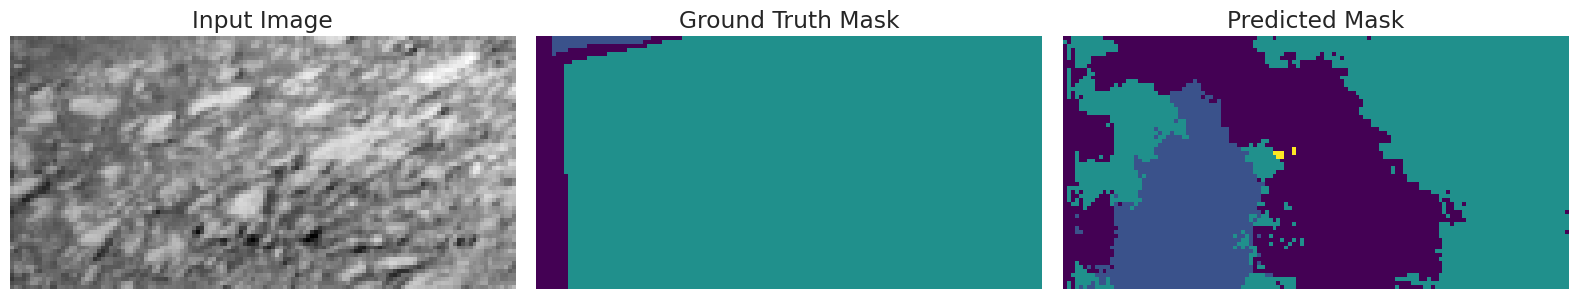

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 756ms/step - accuracy: 0.8776 - loss: 0.8926 - mean_iou: 0.6923 - val_accuracy: 0.7244 - val_loss: 2.2695 - val_mean_iou: 0.4009
Epoch 67/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 672ms/step - accuracy: 0.8798 - loss: 0.8720 - mean_iou: 0.6772 - val_accuracy: 0.7004 - val_loss: 2.6104 - val_mean_iou: 0.4580
Epoch 68/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 669ms/step - accuracy: 0.8828 - loss: 0.8533 - mean_iou: 0.7036 - val_accuracy: 0.6726 - val_loss: 2.1667 - val_mean_iou: 0.3928
Epoch 69/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 674ms/step - accuracy: 0.8942 - loss: 0.7834 - mean_iou: 0.6900 - val_accuracy: 0.7533 - val_loss: 2.1465 - val_mean_iou: 0.4279
Epoch 70/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 667ms/step - accuracy: 0.8943 - loss: 0.7885 - mean_iou: 0.6963 - val_accuracy: 0.7123 - val_loss: 2.0383 - val_mean_iou: 0.4047
Epoch 71/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.8926 - loss: 0.7795 - mean_iou: 0.7052

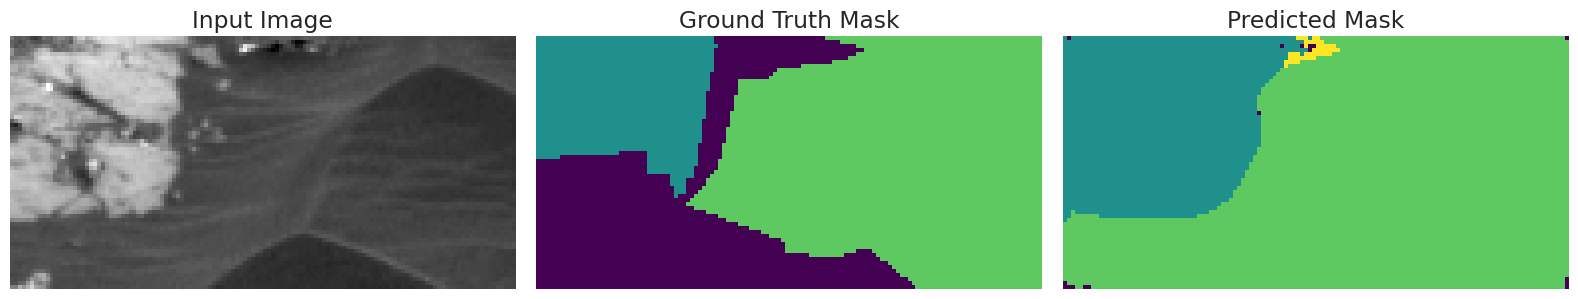

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 733ms/step - accuracy: 0.8935 - loss: 0.7745 - mean_iou: 0.7064 - val_accuracy: 0.6827 - val_loss: 3.2635 - val_mean_iou: 0.4033
Epoch 72/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 660ms/step - accuracy: 0.8972 - loss: 0.7671 - mean_iou: 0.7075 - val_accuracy: 0.6562 - val_loss: 2.6950 - val_mean_iou: 0.4117
Epoch 73/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 665ms/step - accuracy: 0.8864 - loss: 0.8019 - mean_iou: 0.6814 - val_accuracy: 0.6125 - val_loss: 3.5113 - val_mean_iou: 0.3721
Epoch 74/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 664ms/step - accuracy: 0.8893 - loss: 0.8187 - mean_iou: 0.7010 - val_accuracy: 0.6006 - val_loss: 3.3861 - val_mean_iou: 0.3824
Epoch 75/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 664ms/step - accuracy: 0.9002 - loss: 0.7378 - mean_iou: 0.7071 - val_accuracy: 0.7042 - val_loss: 1.9920 - val_mean_iou: 0.3837
Epoch 76/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.8953 - loss: 0.7797 - mean_iou: 0.7099

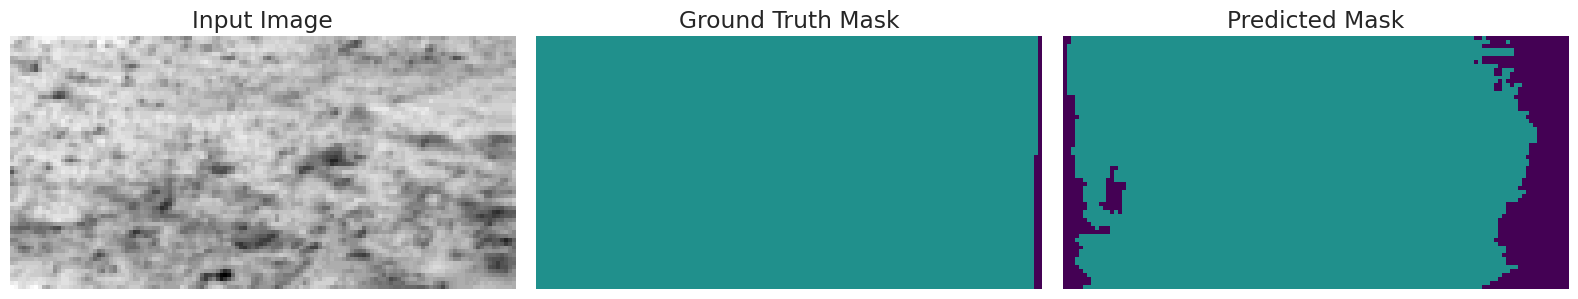

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 733ms/step - accuracy: 0.8961 - loss: 0.7733 - mean_iou: 0.7109 - val_accuracy: 0.6951 - val_loss: 2.1615 - val_mean_iou: 0.3930
Epoch 77/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 662ms/step - accuracy: 0.9001 - loss: 0.7269 - mean_iou: 0.7023 - val_accuracy: 0.6434 - val_loss: 3.4324 - val_mean_iou: 0.3842
Epoch 78/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 662ms/step - accuracy: 0.9015 - loss: 0.7244 - mean_iou: 0.7141 - val_accuracy: 0.6114 - val_loss: 3.1327 - val_mean_iou: 0.2976
Epoch 79/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 668ms/step - accuracy: 0.9051 - loss: 0.6891 - mean_iou: 0.7175 - val_accuracy: 0.6672 - val_loss: 2.7873 - val_mean_iou: 0.4298
Epoch 80/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 668ms/step - accuracy: 0.9105 - loss: 0.6740 - mean_iou: 0.7261 - val_accuracy: 0.6662 - val_loss: 2.8673 - val_mean_iou: 0.4558
Epoch 81/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9145 - loss: 0.6490 - mean_iou: 0.7227

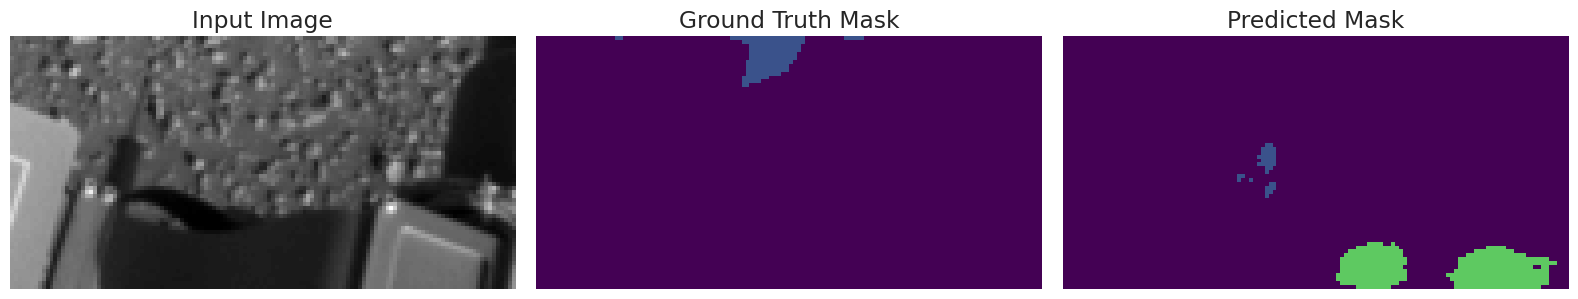

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 745ms/step - accuracy: 0.9146 - loss: 0.6470 - mean_iou: 0.7228 - val_accuracy: 0.6929 - val_loss: 3.2737 - val_mean_iou: 0.4456
Epoch 82/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 664ms/step - accuracy: 0.9102 - loss: 0.6633 - mean_iou: 0.7157 - val_accuracy: 0.6633 - val_loss: 2.3333 - val_mean_iou: 0.4601
Epoch 83/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 665ms/step - accuracy: 0.9214 - loss: 0.6096 - mean_iou: 0.7288 - val_accuracy: 0.6771 - val_loss: 3.6046 - val_mean_iou: 0.3720
Epoch 84/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 669ms/step - accuracy: 0.9162 - loss: 0.6532 - mean_iou: 0.7210 - val_accuracy: 0.7482 - val_loss: 1.6754 - val_mean_iou: 0.5223
Epoch 85/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 667ms/step - accuracy: 0.9002 - loss: 0.7489 - mean_iou: 0.6771 - val_accuracy: 0.6677 - val_loss: 3.1208 - val_mean_iou: 0.3637
Epoch 86/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.9103 - loss: 0.6882 - mean_iou: 0.6886

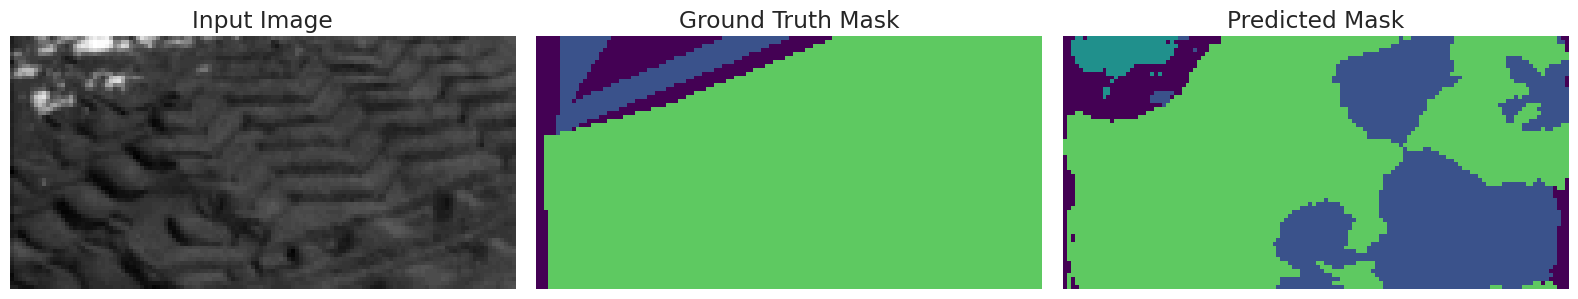

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 759ms/step - accuracy: 0.9116 - loss: 0.6777 - mean_iou: 0.6929 - val_accuracy: 0.7185 - val_loss: 1.9315 - val_mean_iou: 0.4571
Epoch 87/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 669ms/step - accuracy: 0.9100 - loss: 0.6621 - mean_iou: 0.7233 - val_accuracy: 0.6856 - val_loss: 2.5900 - val_mean_iou: 0.4429
Epoch 88/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 666ms/step - accuracy: 0.9128 - loss: 0.6475 - mean_iou: 0.7166 - val_accuracy: 0.5763 - val_loss: 3.8964 - val_mean_iou: 0.3048
Epoch 89/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 665ms/step - accuracy: 0.9178 - loss: 0.6113 - mean_iou: 0.7135 - val_accuracy: 0.6048 - val_loss: 3.4993 - val_mean_iou: 0.3269
Final validation Mean Intersection Over Union: 52.23%


In [43]:
# Train the model
with strategy.scope():
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping, viz_callback],
        verbose=1
    ).history
    
    # Calculate and print the final validation accuracy
    final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
    print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

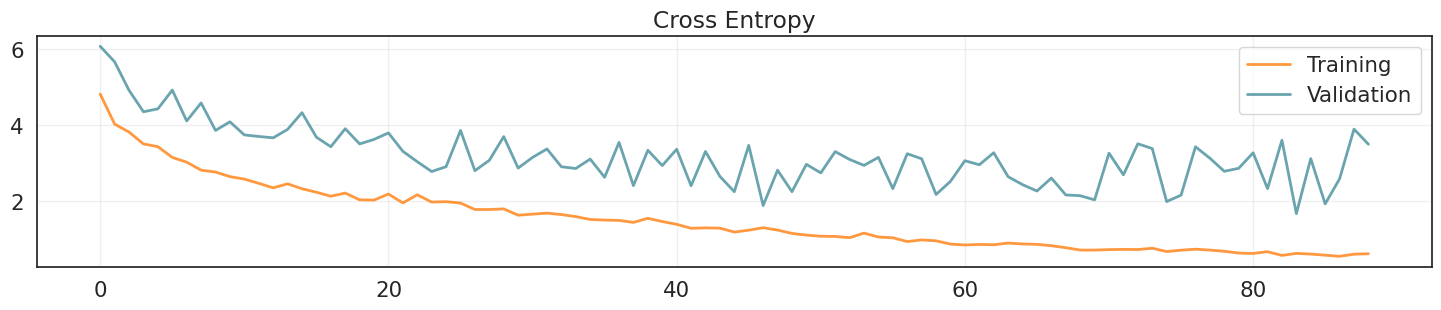

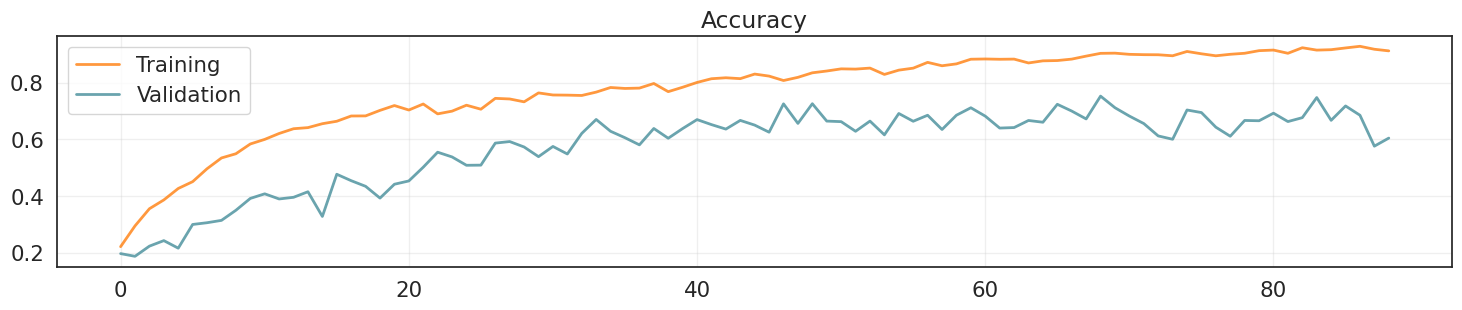

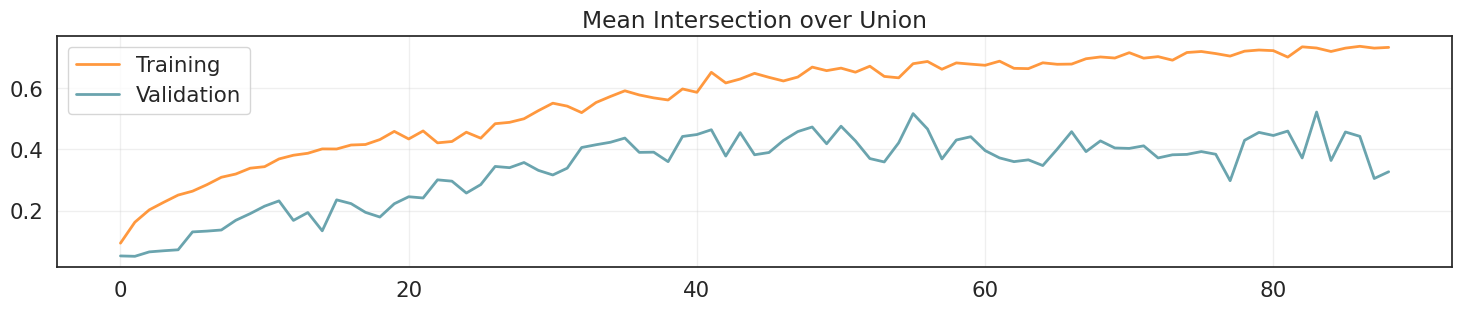

In [44]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


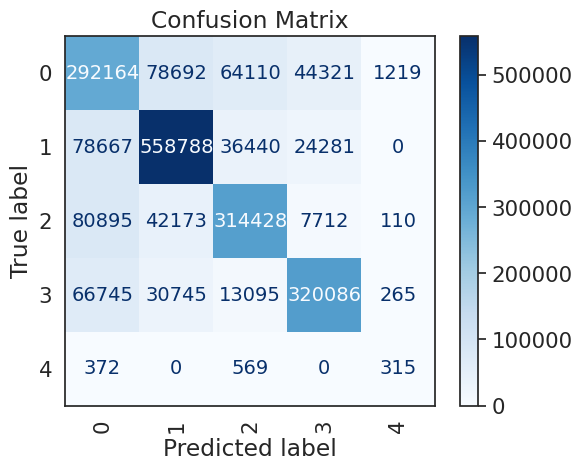

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_data, class_names):
    """
    Plots the confusion matrix for the given model and test data.
    
    Args:
        model: Trained Keras model.
        test_data: A `tf.data.Dataset` or similar iterable with (inputs, labels).
        class_names: List of class names corresponding to the labels.
    """
    # Get ground-truth labels and model predictions
    y_true = []
    y_pred = []
    
    for inputs, labels in test_data:
        predictions = model.predict(inputs)
        y_true.extend(np.argmax(labels.numpy(), axis=-1))
        y_pred.extend(np.argmax(predictions, axis=-1))

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, val_dataset, [0, 1,2,3,4])

In [51]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step
Predictions shape: (10022, 64, 128)


In [52]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [53]:
from time import time

# Create and download the csv submission file
timestep_str = int(time())
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)